In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

In [3]:
#Read Dataset
data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/3_Apple/Apple.csv'
df = pd.read_csv(data_path)
df.head()

,Index,Rating_Number,Work_Life,Benefits,Job_Advancement,Management,Culture,Review_Title,Reviewer_Job_Title,Reviewer_Job_Status,Reviewer_Job_Location,Reviewed_Date,Review_Text,Pros,Cons
0,0,5.0,5.0,5.0,5.0,5.0,5.0,The Best Job Ever,Part time Specialist,Former Employee,"Towson, MD","January 22, 2019",Working at Apple was a great experience. Work ...,Work environment,Parking
1,1,5.0,4.0,4.0,5.0,5.0,5.0,"Great company, limited advancement at Austin c...",Supply Demand Planning,Former Employee,"Austin, TX","July 14, 2019",Great company with good compensation the Aust...,NaN,NaN
2,2,1.0,1.0,1.0,1.0,1.0,1.0,Poor work environment,Technical Support Representative,Former Employee,"Southfield, MI","July 14, 2019",I worked for an outsourced company of Apple Ca...,NaN,NaN
3,3,2.0,1.0,1.0,1.0,1.0,1.0,No te haces ilusiones ;-),Teleoperador comercial,Current Employee,Online,"July 14, 2019",Por el trabajo que haces el pago es malisimo. ...,Teleoperador/a,Demasiado manipulación desde el fondo
4,4,5.0,5.0,1.0,5.0,5.0,5.0,Work place,Customer Service,Minacs,"Southfield, MI","July 14, 2019",Work environment was ok always over time avail...,NaN,NaN


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'apple'])

In [5]:
#Make data

#Pros
df_subset = df[['Cons']]
df_subset.dropna(inplace=True)
display(df_subset.head())
data = df_subset.Cons.values.tolist()

#Rating
# df_subset = df.loc[df['Rating_Number'] > 3]
# df_subset = df_subset [['Review_Text']]
# df_subset.dropna(inplace=True)
# display(df_subset.head())
# data = df_subset.Review_Text.values.tolist()
print(len(data))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Cons
0,Parking
3,Demasiado manipulación desde el fondo
13,"management, work flow, lack of opportunity"
19,"Long hours, etc."
20,The weekly work schedule was too arbitrary.


2761


In [6]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# pprint(data[:1])
data[:1]

['Parking']

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['parking']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['nothing']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])
print(data_lemmatized[5])

['nothing']


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(len(id2word))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])
print(corpus[5])

1829
[(15, 1)]


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('parking', 1)]]

In [15]:
# %%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.160*"work" + 0.062*"schedule" + 0.061*"hard" + 0.059*"pay" + '
  '0.031*"company" + 0.029*"move" + 0.026*"environment" + 0.025*"lot" + '
  '0.021*"nothing" + 0.020*"many"'),
 (1,
  '0.081*"store" + 0.057*"weekend" + 0.054*"strict" + '
  '0.039*"attendance_policy" + 0.031*"high_stress" + 0.027*"sale" + '
  '0.027*"competitive" + 0.023*"healthcare" + 0.022*"mall" + 0.021*"pressure"'),
 (2,
  '0.062*"employee" + 0.061*"room" + 0.057*"home" + 0.041*"not" + '
  '0.036*"low_pay" + 0.031*"enough" + 0.029*"full_time" + 0.029*"issue" + '
  '0.029*"do" + 0.020*"expectation"'),
 (3,
  '0.107*"time" + 0.068*"busy" + 0.064*"position" + 0.057*"manager" + '
  '0.051*"long_hour" + 0.044*"sometimes" + 0.039*"stressful" + 0.032*"hire" + '
  '0.031*"extremely" + 0.028*"stand"'),
 (4,
  '0.107*"advancement" + 0.087*"balance" + 0.087*"work_life" + 0.060*"lack" + '
  '0.055*"benefit" + 0.032*"low" + 0.031*"poor" + 0.029*"limited" + '
  '0.027*"opportunity" + 0.026*"part_time"'),
 (5,
  '0.077*"ret

In [17]:
# lda_model.score(data_vectorized)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.585888943566382

Coherence Score:  0.5968200913549878


In [19]:
# %%time
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.395730 -0.004344       1        1  19.483835
5     -0.072067 -0.166407       2        1  13.701267
4     -0.049268  0.363431       3        1  13.326279
2     -0.046440 -0.031864       4        1  10.113513
6     -0.042763 -0.030441       5        1   9.323850
3     -0.040385 -0.029629       6        1   9.125962
9     -0.037898 -0.026410       7        1   7.374480
7     -0.036316 -0.025369       8        1   6.502105
8     -0.037432 -0.025234       9        1   6.084866
1     -0.033161 -0.023733      10        1   4.963846, topic_info=     Category        Freq                Term       Total  loglift  logprob
8     Default  212.000000          management  212.000000  30.0000  30.0000
10    Default  304.000000                work  304.000000  29.0000  29.0000
32    Default  146.000000                hour  146.000000  28.0000  28.0000
72    Default  140.000000         advancement  140.000000  27.0000  27.0000
21    Default   96.000000                time   96.000000  26.0000  26.0000
30    Default  114.000000             balance  114.000000  25.0000  25.0000
31    Default  114.000000           work_life  114.000000  24.0000  24.0000
56    Default   90.000000            customer   90.000000  23.0000  23.0000
207   Default  104.000000              retail  104.000000  22.0000  22.0000
13    Default  119.000000            schedule  119.000000  21.0000  21.0000
115   Default  117.000000                hard  117.000000  20.0000  20.0000
85    Default  113.000000                 pay  113.000000  19.0000  19.0000
49    Default   88.000000                none   88.000000  18.0000  18.0000
239   Default   84.000000        compensation   84.000000  17.0000  17.0000
87    Default   81.000000                 get   81.000000  16.0000  16.0000
7     Default   79.000000                lack   79.000000  15.0000  15.0000
61    Default   55.000000                 day   55.000000  14.0000  14.0000
117   Default   61.000000                busy   61.000000  13.0000  13.0000
319   Default   55.000000              little   55.000000  12.0000  12.0000
274   Default   61.000000                 job   61.000000  11.0000  11.0000
44    Default   72.000000             benefit   72.000000  10.0000  10.0000
138   Default   62.000000            employee   62.000000   9.0000   9.0000
102   Default   50.000000               break   50.000000   8.0000   8.0000
320   Default   60.000000                room   60.000000   7.0000   7.0000
47    Default   57.000000            position   57.000000   6.0000   6.0000
191   Default   56.000000                home   56.000000   5.0000   5.0000
97    Default   51.000000             manager   51.000000   4.0000   4.0000
290   Default   39.000000               store   39.000000   3.0000   3.0000
23    Default   47.000000              growth   47.000000   2.0000   2.0000
11    Default   46.000000           long_hour   46.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
290   Topic10   39.046356               store   39.854237   2.9825  -2.5192
182   Topic10   27.805479             weekend   28.613314   2.9744  -2.8587
203   Topic10   26.047798              strict   26.855648   2.9724  -2.9240
945   Topic10   18.686590   attendance_policy   19.494537   2.9607  -3.2562
471   Topic10   14.825276         high_stress   15.633152   2.9499  -3.4876
20    Topic10   13.326741                sale   14.134569   2.9441  -3.5942
206   Topic10   13.202573         competitive   14.010487   2.9436  -3.6036
43    Topic10   11.080200          healthcare   11.888022   2.9326  -3.7788
690   Topic10   10.815360                mall   11.623198   2.9310  -3.8030
19    Topic10   10.261122            pressure   11.068942   2.9272  -3.8556
17    Topic10    9.289392             certain   10.097368   2.9196  -3.9551
321   Topic10    9.215498               s

In [ ]:
# %%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('job', 0.19715731667922903),
   ('management', 0.10972326908581889),
   ('learn', 0.05814579519758803),
   ('hardest_part', 0.032518574351243675),
   ('enjoyable_part', 0.024658124259717886),
   ('deal', 0.021320124905782275),
   ('coworker', 0.016151609777107785),
   ('enjoy', 0.01582857758156563),
   ('customer_service', 0.015505545386023474),
   ('helpful', 0.01356735221277054)]),
 (1,
  [('people', 0.15581167772099597),
   ('make', 0.07698162444275307),
   ('work', 0.06969664020876373),
   ('amazing', 0.04457975426769599),
   ('thing', 0.03468522344242688),
   ('culture', 0.03414156790257693),
   ('meet', 0.026856583668587584),
   ('balance', 0.02576927258888768),
   ('feel', 0.02576927258888768),
   ('work_life', 0.023050994889637924)]),
 (2,
  [('great', 0.1446357042329761),
   ('good', 0.1039298473530367),
   ('work', 0.09765075240879073),
   ('benefit', 0.08541734329327703),
   ('place', 0.06354877124607557),
   ('pay', 0.05066580058460539),
   ('awesome', 0.0260907220

In [26]:
# %%time
lda_model_mallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [99]:
ldamallet.alpha

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [100]:
ldamallet.num_topics

10

In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_mallet, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.208532  0.274388       1        1  10.641680
8     -0.186205 -0.044670       2        1  10.552309
6     -0.234994  0.179040       3        1  10.276673
0     -0.187840 -0.129087       4        1  10.048262
5     -0.103949 -0.309827       5        1  10.041748
9      0.039922 -0.138683       6        1   9.965370
1      0.142291  0.003371       7        1   9.906635
3      0.205524  0.082528       8        1   9.710799
2      0.254929  0.021414       9        1   9.494352
4      0.278854  0.061526      10        1   9.362173, topic_info=     Category         Freq                 Term        Total  loglift  logprob
36    Default  6022.000000                 work  6022.000000  30.0000  30.0000
15    Default  2215.000000                  job  2215.000000  29.0000  29.0000
5     Default  2214.000000              company  2214.000000  28.0000  28.0000
13    Default  2811.000000                great  2811.000000  27.0000  27.0000
140   Default  1726.000000               people  1726.000000  26.0000  26.0000
33    Default  1378.000000                 time  1378.000000  25.0000  25.0000
44    Default  1255.000000           management  1255.000000  24.0000  24.0000
178   Default  1687.000000             customer  1687.000000  23.0000  23.0000
8     Default  1091.000000             employee  1091.000000  22.0000  22.0000
50    Default  1003.000000          environment  1003.000000  21.0000  21.0000
42    Default  1614.000000                 good  1614.000000  20.0000  20.0000
3     Default   915.000000              benefit   915.000000  19.0000  19.0000
17    Default   852.000000                 make   852.000000  18.0000  18.0000
10    Default   872.000000           experience   872.000000  17.0000  17.0000
107   Default   838.000000                  day   838.000000  16.0000  16.0000
129   Default  1124.000000                learn  1124.000000  15.0000  15.0000
298   Default   728.000000                  lot   728.000000  14.0000  14.0000
16    Default   673.000000                 love   673.000000  13.0000  13.0000
245   Default   674.000000                place   674.000000  12.0000  12.0000
74    Default   860.000000              product   860.000000  11.0000  11.0000
47    Default   813.000000                 team   813.000000  10.0000  10.0000
63    Default   627.000000               retail   627.000000   9.0000   9.0000
26    Default   591.000000                 part   591.000000   8.0000   8.0000
18    Default   588.000000              manager   588.000000   7.0000   7.0000
191   Default   574.000000                  fun   574.000000   6.0000   6.0000
31    Default   590.000000                store   590.000000   5.0000   5.0000
27    Default   537.000000                  pay   537.000000   4.0000   4.0000
24    Default   580.000000          opportunity   580.000000   3.0000   3.0000
192   Default   469.000000          great_place   469.000000   2.0000   2.0000
1     Default   589.000000              amazing   589.000000   1.0000   1.0000
...       ...          ...                  ...          ...      ...      ...
333   Topic10   123.782041      would_recommend   124.975273   2.3589  -4.4378
748   Topic10    43.206939              relaxed    43.206939   2.3685  -5.4903
315   Topic10    43.206939                 pace    43.206939   2.3685  -5.4903
1127  Topic10    40.871429            new_thing    40.871429   2.3685  -5.5458
308   Topic10    33.864898          challenging    33.864898   2.3685  -5.7339
189   Topic10    99.259184             exciting   100.429055   2.3568  -4.6585
190   Topic10    95.755919            fast_pace    96.905417   2.3566  -4.6945
625   Topic10    23.355102            temporary    23.355102   2.3685  -6.1055
484   Topic10    22.187347     would_definitely    22.187347   2.3685  -6.1568
2267  Topic10    18.684082         smart_people    18.684082   2.3685 

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [31]:
# %%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

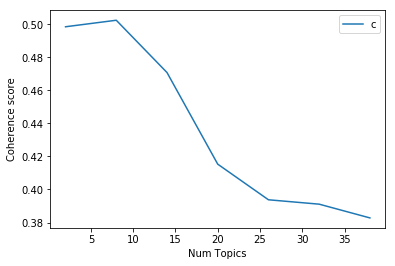

In [32]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=10, step=1)

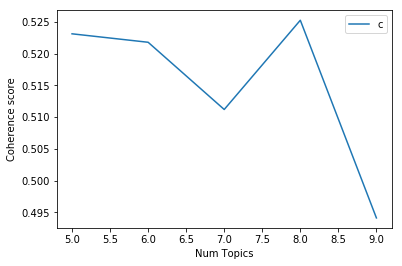

In [34]:
# Show graph
limit=10; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5231
Num Topics = 6  has Coherence Value of 0.5218
Num Topics = 7  has Coherence Value of 0.5112
Num Topics = 8  has Coherence Value of 0.5252
Num Topics = 9  has Coherence Value of 0.4941


In [36]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.246*"work" + 0.106*"great" + 0.077*"environment" + 0.053*"lot" + '
  '0.044*"fun" + 0.043*"management" + 0.036*"great_place" + 0.026*"enjoy" + '
  '0.018*"friendly" + 0.018*"nice"'),
 (1,
  '0.184*"work" + 0.120*"good" + 0.051*"place" + 0.050*"love" + '
  '0.043*"amazing" + 0.032*"hard" + 0.026*"manager" + 0.021*"awesome" + '
  '0.021*"people" + 0.020*"start"'),
 (2,
  '0.088*"time" + 0.040*"pay" + 0.032*"position" + 0.031*"home" + 0.027*"hour" '
  '+ 0.026*"year" + 0.021*"schedule" + 0.020*"balance" + 0.020*"work" + '
  '0.018*"leave"'),
 (3,
  '0.145*"job" + 0.048*"customer" + 0.047*"management" + 0.046*"learn" + '
  '0.032*"part" + 0.027*"issue" + 0.025*"hardest_part" + '
  '0.021*"customer_service" + 0.019*"enjoyable_part" + 0.017*"deal"'),
 (4,
  '0.056*"team" + 0.028*"training" + 0.026*"support" + 0.016*"sale" + '
  '0.015*"business" + 0.014*"role" + 0.014*"high" + 0.013*"develop" + '
  '0.012*"create" + 0.011*"development"'),
 (5,
  '0.158*"company" + 0.105*"great" + 0

In [101]:
print(optimal_model.alpha)
print(optimal_model.num_topics)
print(optimal_model.random_seed)
print(optimal_model.topic_threshold)
print(optimal_model.iterations)

[6.25 6.25 6.25 6.25 6.25 6.25 6.25 6.25]
8
0
0.0
1000


In [37]:
optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.131107  0.215645       1        1  13.050094
6     -0.211425  0.100628       2        1  12.884001
3     -0.201144 -0.188972       3        1  12.876960
7     -0.176219 -0.234502       4        1  12.675869
2      0.079747  0.108492       5        1  12.618279
1      0.248191 -0.174328       6        1  12.101875
5      0.102374  0.241870       7        1  12.003846
0      0.289582 -0.068833       8        1  11.789077, topic_info=     Category         Freq                 Term        Total  loglift  logprob
36    Default  6012.000000                 work  6012.000000  30.0000  30.0000
5     Default  2122.000000              company  2122.000000  29.0000  29.0000
15    Default  2212.000000                  job  2212.000000  28.0000  28.0000
13    Default  2809.000000                great  2809.000000  27.0000  27.0000
42    Default  1626.000000                 good  1626.000000  26.0000  26.0000
140   Default  1731.000000               people  1731.000000  25.0000  25.0000
33    Default  1359.000000                 time  1359.000000  24.0000  24.0000
178   Default  1735.000000             customer  1735.000000  23.0000  23.0000
50    Default  1009.000000          environment  1009.000000  22.0000  22.0000
8     Default  1024.000000             employee  1024.000000  21.0000  21.0000
74    Default   884.000000              product   884.000000  20.0000  20.0000
17    Default   860.000000                 make   860.000000  19.0000  19.0000
44    Default  1239.000000           management  1239.000000  18.0000  18.0000
3     Default   915.000000              benefit   915.000000  17.0000  17.0000
47    Default   812.000000                 team   812.000000  16.0000  16.0000
129   Default  1143.000000                learn  1143.000000  15.0000  15.0000
105   Default   747.000000              culture   747.000000  14.0000  14.0000
298   Default   701.000000                  lot   701.000000  13.0000  13.0000
245   Default   689.000000                place   689.000000  12.0000  12.0000
16    Default   678.000000                 love   678.000000  11.0000  11.0000
107   Default   855.000000                  day   855.000000  10.0000  10.0000
63    Default   599.000000               retail   599.000000   9.0000   9.0000
10    Default   887.000000           experience   887.000000   8.0000   8.0000
191   Default   577.000000                  fun   577.000000   7.0000   7.0000
1     Default   578.000000              amazing   578.000000   6.0000   6.0000
27    Default   563.000000                  pay   563.000000   5.0000   5.0000
24    Default   554.000000          opportunity   554.000000   4.0000   4.0000
192   Default   472.000000          great_place   472.000000   3.0000   3.0000
87    Default   449.000000             position   449.000000   2.0000   2.0000
88    Default   505.000000              provide   505.000000   1.0000   1.0000
...       ...          ...                  ...          ...      ...      ...
234    Topic8   140.969757              working   140.969757   2.1380  -4.5382
521    Topic8   108.076814          learned_lot   108.076814   2.1380  -4.8039
304    Topic8   102.203074             flexible   102.203074   2.1380  -4.8598
1059   Topic8    98.678830                 fast    98.678830   2.1380  -4.8949
190    Topic8    97.504082            fast_pace    97.504082   2.1380  -4.9069
174    Topic8    93.979838            workplace    93.979838   2.1380  -4.9437
486    Topic8   243.172831             friendly   245.523098   2.1284  -3.9930
921    Topic8    75.183870            learn_lot    75.183870   2.1380  -5.1668
259    Topic8    58.737399            colleague    58.737399   2.1380  -5.4137
377    Topic8    54.038407             pressure    54.038407   2.1380  -5.4971
143    Topic8    49.339415                 real    49.339415   2.1380  -5.5881
932    Topic8    49.

In [42]:
pd.set_option('display.max_colwidth', -1)

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
display(df_dominant_topic.head(10))
df
print(df_dominant_topic.iloc[[0]].Keywords.values)
print(df_dominant_topic.iloc[[0]].Text.values)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1689,"work, good, place, love, amazing, hard, manager, awesome, people, start","Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy. Id say electric because the experience was exhilarating. The managers were all great and they were never above doing what they asked of their employees. The benefits and pay were amazing for a part time job. Working for a company with a brand such as Apple and experience to match that brand made me want to stay forever. This is a job I truly miss and I am thankful for the opportunity that I was given!"
1,1,5.0,0.1874,"company, great, employee, benefit, culture, retail, opportunity, experience, grow, excellent",Great company with good compensation the Austin campus had limited opportunities for advancement and doing different things it seemed. Management and teams were skilled
2,2,3.0,0.1589,"job, customer, management, learn, part, issue, hardest_part, customer_service, enjoyable_part, deal","Work environment was ok always over time available. The supervisors were nice, management was always open and available if you and a issues and were good with resolving you issues"
3,3,1.0,0.1914,"work, good, place, love, amazing, hard, manager, awesome, people, start","Apple has great benefits and has great job security. But it’s very hard to move up or anywhere in the company and switching from Retail to Corporate is practically non existent, so if you’re looking to do corporate, don’t start with retail."
4,4,7.0,0.1528,"people, make, day, learn, thing, skill, technology, life, meet, change",As a company apple is not afraid to take risks and explore new ideas. The partnership between design and engineering is what makes the companys products special.
5,5,5.0,0.1655,"company, great, employee, benefit, culture, retail, opportunity, experience, grow, excellent",Great company to work for. Management is wonderful to employees. They make sure they provide home/work blance in your life.they make sure you receive the time off the floor traning to help you too achieve your goal to advance to another position within store.
6,6,2.0,0.2073,"time, pay, position, home, hour, year, schedule, balance, work, leave","I learned an immense amount about being an adult with a ""real"" job during my six years at Apple. The culture was incredible, the opportunities to learn every aspect of the retail business were readily available, and the benefits are unparalleled (even for part-time workers) in the retail world. Depending on the store leader, it was fairly easy to have a schedule that worked around your life despite the business requirements of covering 12-14 operating hours, seven days per week.There were many opportunities to move laterally within the company, but unfortunately there wasnt much room at the top. A typical store with 100-120 employees only had positions for 4-6 lead positions and 10-12 managers of different levels. You really had to be willing to move where the jobs were if you wanted to advance, especially because the senior and general manager (store leader) positions were usually filled externally by people taking a pay- or responsibility-level-cut to work for Apple. On the other hand, if you are young and unattached, Apple makes it easy to move to nearly any mid-size or larger city in the world!The biggest downside is that this is, at the end of the day, just a retail job. Most stores are housed in malls and shopping centers. Your pay, while at the top of comparable jobs, probably wont be enough to support a family and a mortgage (if thats something you want or have). Unless youre willing to live in California or Texas, you wont be able to get a corporate job where you could really have opportunities to make a living wage. And you will always, always,"
7,7,5.0,0.1793,"company, great, employee, be

['work, good, place, love, amazing, hard, manager, awesome, people, start']
['Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy. Id say electric because the experience was exhilarating. The managers were all great and they were never above doing what they asked of their employees. The benefits and pay were amazing for a part time job. Working for a company with a brand such as Apple and experience to match that brand made me want to stay forever. This is a job I truly miss and I am thankful for the opportunity that I was given!']


In [41]:
pd.set_option('display.max_colwidth', -1)

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2307,"work, great, environment, lot, fun, management, great_place, enjoy, friendly, nice","Productive and fun work place ,a lot of hardworking people .easy to work to this environment ,a lot of overtime no hassle and friendly staff..I like working to this kind of job and very easy for me"
1,1.0,0.2490,"work, good, place, love, amazing, hard, manager, awesome, people, start","The coolest thing about working for Apple was simply that... working for Apple. Its a retail job, nothing more. The Apple culture and the amazing folks that brings into your store is what keeps you working there. Unfortunately, I had a few managers that were seriously lacking, so I left after only a year... but the company as a whole is amazing. I have several life long friends because of my time with Apple and know a few people that even headed to Cupertino to work for corporate. It was a really cool year."
2,2.0,0.5311,"time, pay, position, home, hour, year, schedule, balance, work, leave","apple is good companygood at coding and good at communicationWelcome to the website. If youre here, youre likely looking to find random words. Random Word Generator is the perfect tool to help you do this. While this tool isnt a word creator, it is a word generator that will generate random words for a variety of activities or uses. Even better, it allows you to adjust the parameters of the random words to best fit your needs.The first option the tool allows you to adjust is the number of random words to be generated. You can choose as many or as few as youd like. You also have the option of choosing words that only begin with a certain letter, only end with a certain letter or only begin and end with certain letters. If you leave these blank, the randomize words that appear will be from the complete list.You also have the option of choosing the number of syllables of the words or the word length of the randomized words. There are also options to further refine by choosing ""less than"" or ""greater than"" options for both syllables and word length. Again, if you leave the space blank, the complete list of randomized words will be used.Once you have input all of your specifications, all you have to do is to press the Generate Random Words button, and a list of random words will appear. Below are some of the common ways people use this tool.GamesThis tool can be useful for games like Pictionary or MadLibs. Since the words are random, this helps to keep a game like Pictionary fair for all those playing. For a game like MadLibs, it can help kids improve"
3,3.0,0.4167,"job, customer, management, learn, part, issue, hardest_part, customer_service, enjoyable_part, deal","A typical day at work for me is answering anywhere between 20 to 30 plus phone calls in a 10 hour shift. The majority of my phone calls right now consist of setting up and troubleshooting wireless networks created by Apple AirPort routers as well as troubleshooting Apple TVs which are media streaming devices. I have learned much at Apple such as, how to deal with angry and difficult customers in a polite and professional matter, how to empathize with customers, and also how to extensively troubleshoot most Apple products. I feel most comfortable troubleshooting Apple computers and wireless networks. As far as management goes, I can honestly say I have never had any issues really with management. All of my managers have been very easy to get along with and work with as well. The same is true with my coworkers. The hardest part of my job would definitely have to be dealing with the angrier customers and keeping them on track so that we can find the solution for their problem. The most enjoyable part of my job for me is helping people and seeing their issues resolved so that they can get on with their day to day lives."
4,4.0,0.6057,"team, training, support, sale, business, role, high, develop, create, development","Provided 24x7 support for Apple Inc data ce

In [43]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics

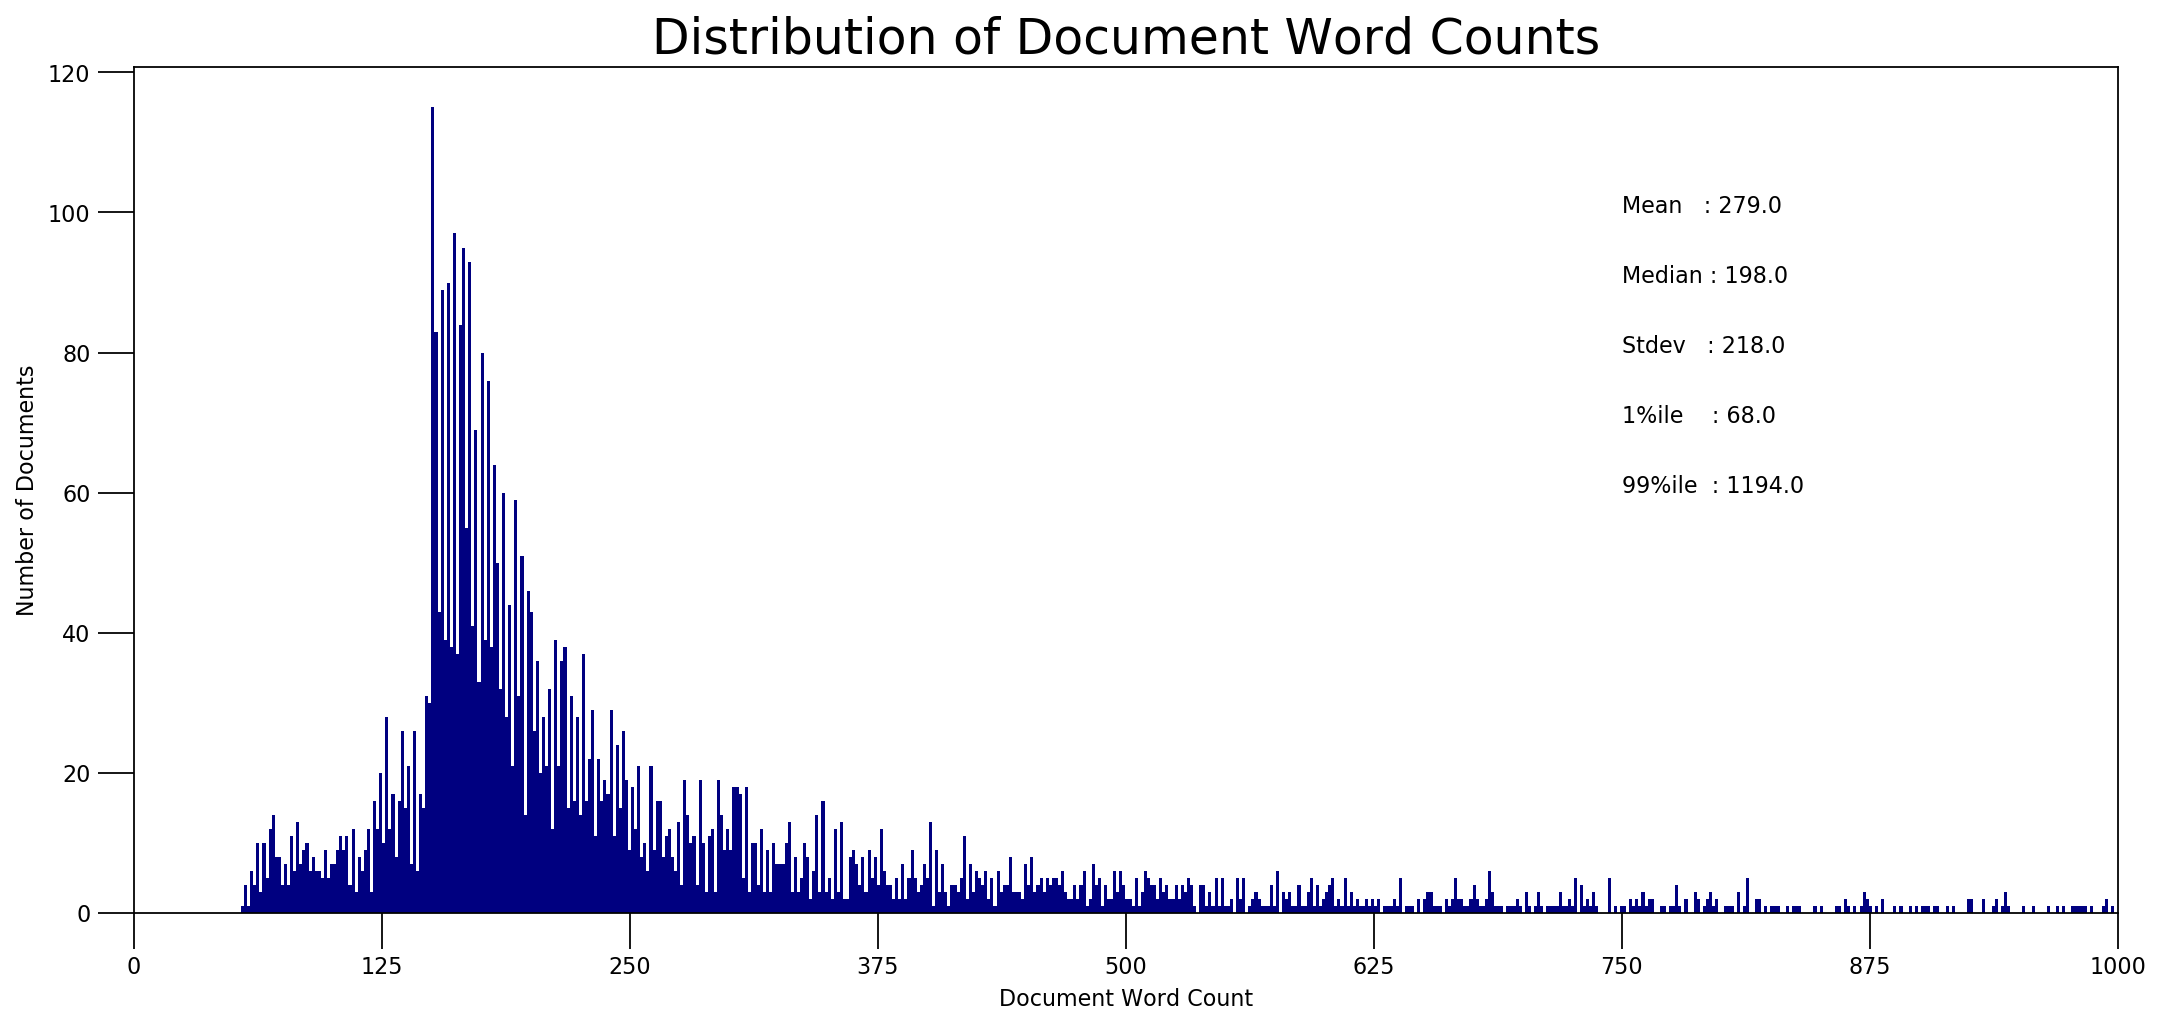

In [44]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

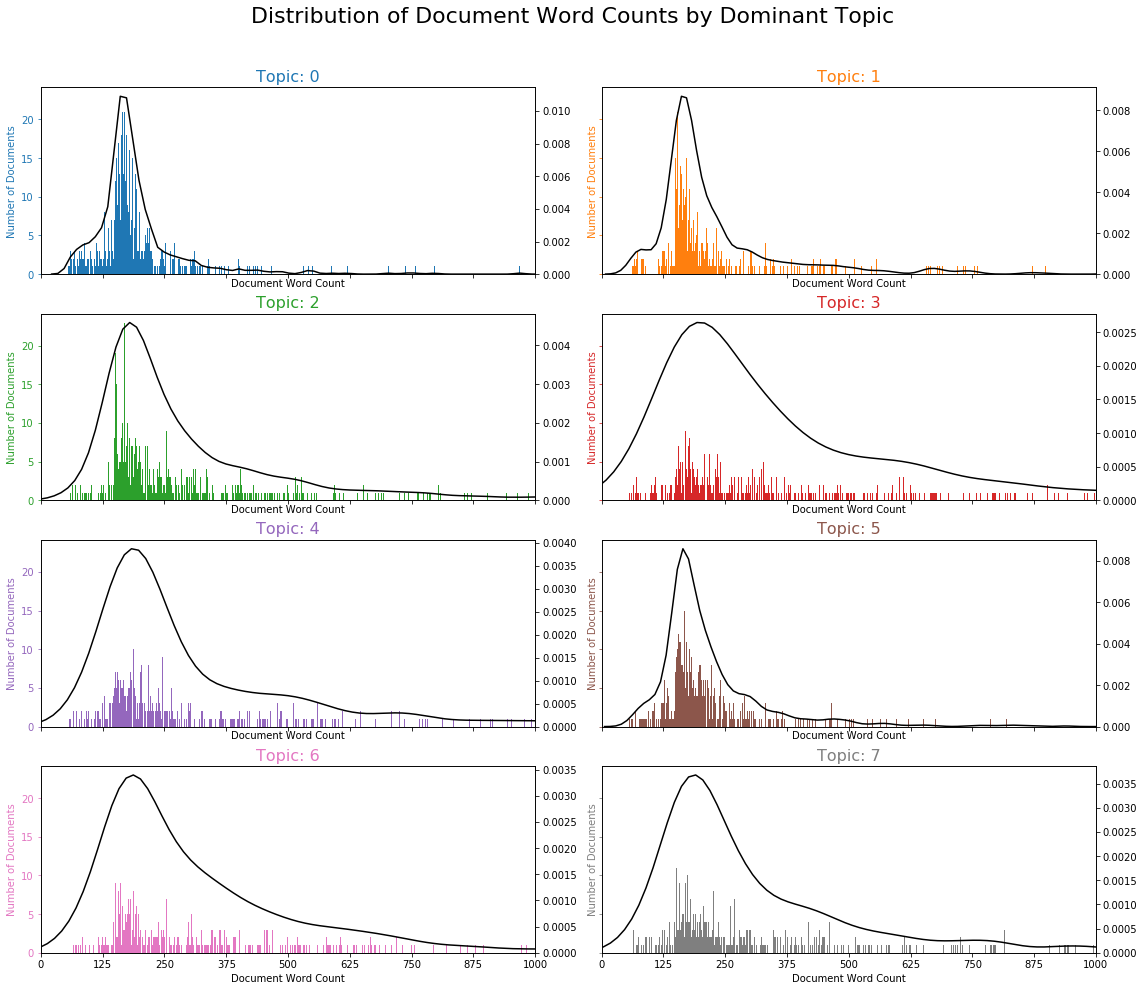

In [60]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)
fig, axes = plt.subplots(4,2,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

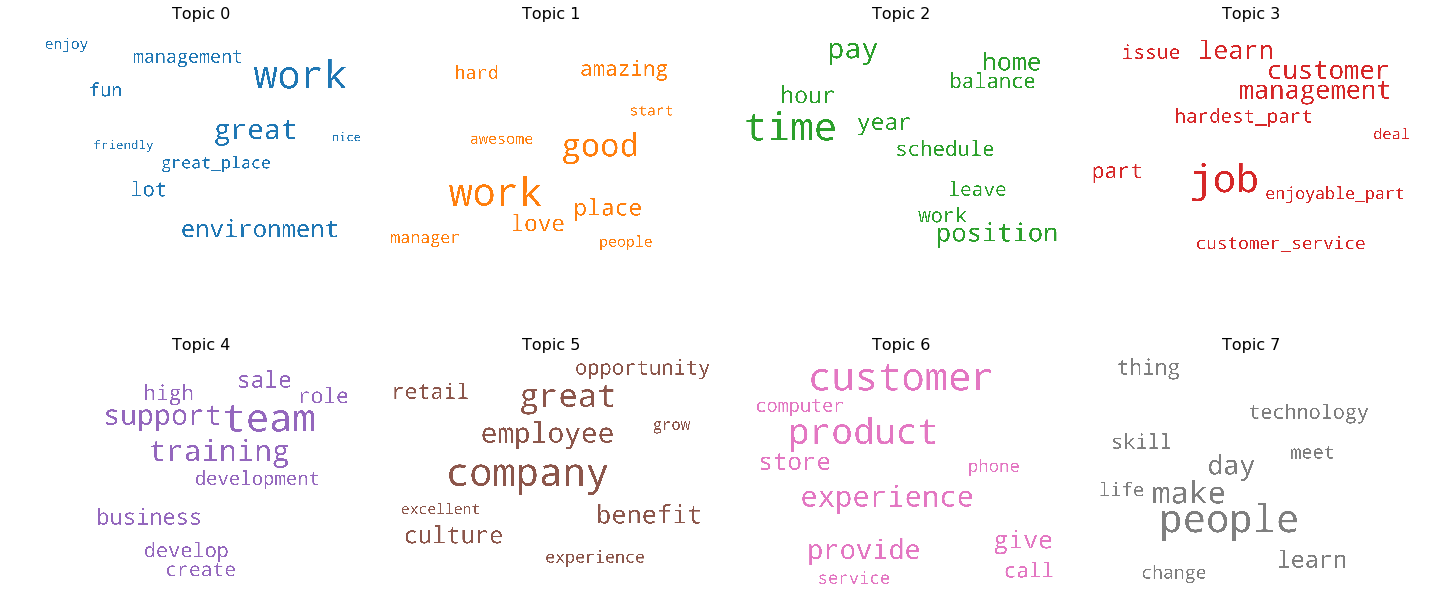

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

,word,topic_id,importance,word_count
0,work,0,0.246013,5112
1,great,0,0.106032,2422
2,environment,0,0.076539,859
3,lot,0,0.053194,597
4,fun,0,0.043839,492


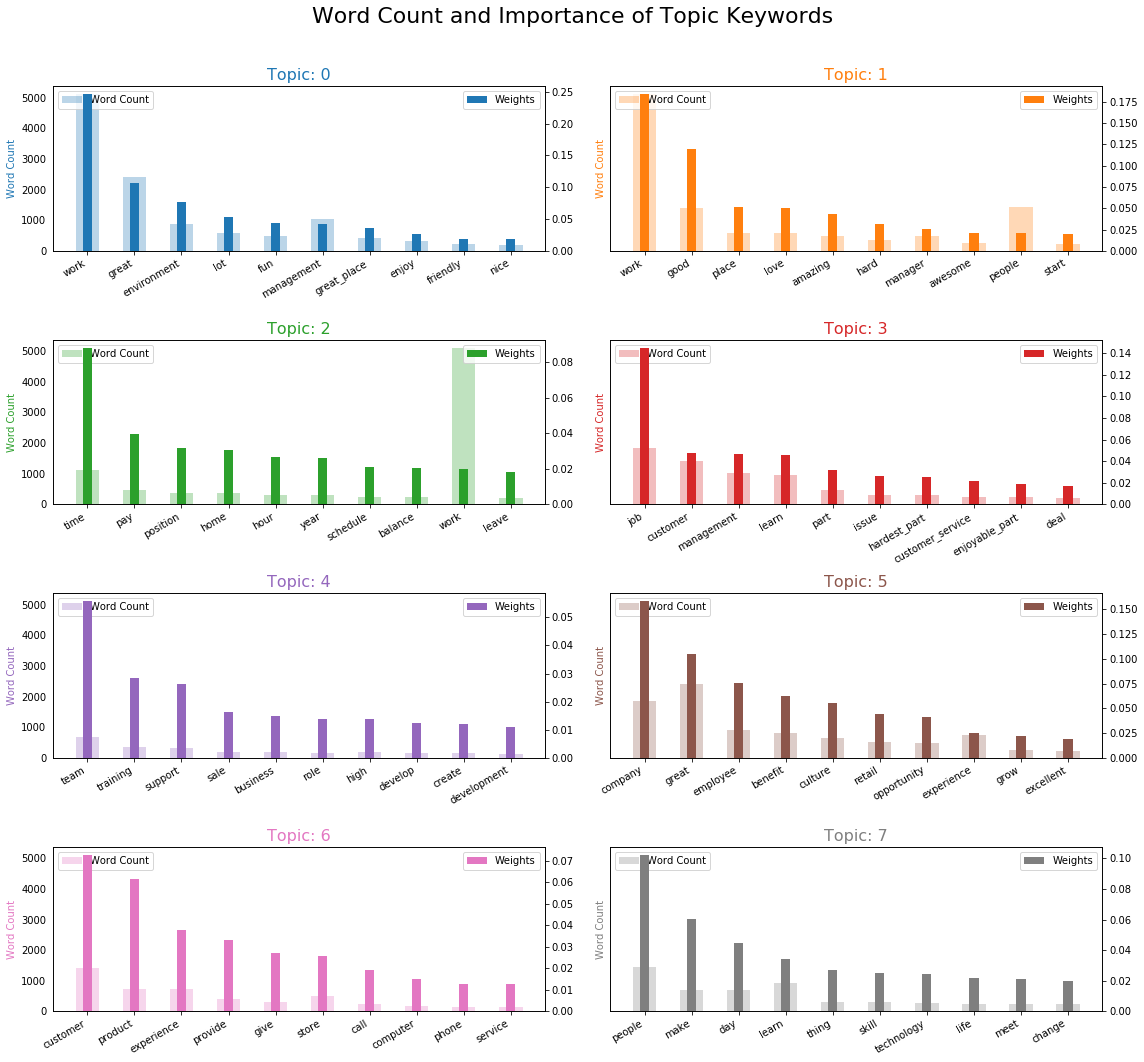

In [71]:
from collections import Counter

# model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

topics = optimal_model.show_topics(formatted=False)
# print(data)
# print(w_list)
# data_ready
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)
# print(counter)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
display(df.head())
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,14), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=0,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
                                           alpha=6.25,
                                           iterations = 1000,
                                           per_word_topics=True)

In [103]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.006137 -0.001701  1       1        12.562561
0     -0.001248  0.005665  2       1        12.534226
4     -0.000414 -0.000065  3       1        12.500373
6      0.000131 -0.001130  4       1        12.494776
1      0.002597  0.000758  5       1        12.487952
2      0.000307 -0.002749  6       1        12.481465
3      0.004465 -0.000993  7       1        12.472501
5      0.000300  0.000214  8       1        12.466146, topic_info=    Category         Freq            Term        Total  loglift  logprob
36   Default  4653.000000  work            4653.000000  30.0000  30.0000
15   Default  1778.000000  job             1778.000000  29.0000  29.0000
13   Default  2190.000000  great           2190.000000  28.0000  28.0000
129  Default  1108.000000  learn           1108.000000  27.0000  27.0000
74   Default  895.000000   product         895.000000   26.0000  26.0000
42   Default  1223.000000  good            1223.000000  25.0000  25.0000
5    Default  1708.000000  company         1708.000000  24.0000  24.0000
140  Default  1452.000000  people          1452.000000  23.0000  23.0000
83   Default  659.000000   help            659.000000   22.0000  22.0000
50   Default  808.000000   environment     808.000000   21.0000  21.0000
31   Default  541.000000   store           541.000000   20.0000  20.0000
44   Default  1025.000000  management      1025.000000  19.0000  19.0000
0    Default  500.000000   always          500.000000   18.0000  18.0000
47   Default  658.000000   team            658.000000   17.0000  17.0000
298  Default  524.000000   lot             524.000000   16.0000  16.0000
16   Default  568.000000   love            568.000000   15.0000  15.0000
120  Default  852.000000   get             852.000000   14.0000  14.0000
12   Default  302.000000   give            302.000000   13.0000  13.0000
197  Default  299.000000   technology      299.000000   12.0000  12.0000
210  Default  385.000000   go              385.000000   11.0000  11.0000
186  Default  481.000000   would           481.000000   10.0000  10.0000
17   Default  683.000000   make            683.000000   9.0000   9.0000 
72   Default  426.000000   new             426.000000   8.0000   8.0000 
273  Default  448.000000   need            448.000000   7.0000   7.0000 
10   Default  701.000000   experience      701.000000   6.0000   6.0000 
8    Default  795.000000   employee        795.000000   5.0000   5.0000 
3    Default  553.000000   benefit         553.000000   4.0000   4.0000 
290  Default  590.000000   well            590.000000   3.0000   3.0000 
245  Default  501.000000   place           501.000000   2.0000   2.0000 
105  Default  484.000000   culture         484.000000   1.0000   1.0000 
..       ...         ...       ...                ...      ...      ... 
13   Topic8   291.552063   great           2190.367188  0.0655  -3.8674 
243  Topic8   38.384735    deal            236.165680   0.2653  -5.8950 
129  Topic8   154.620178   learn           1108.872314  0.1120  -4.5016 
219  Topic8   49.473602    much            315.712158   0.2288  -5.6412 
306  Topic8   50.968388    training        326.756470   0.2241  -5.6114 
122  Topic8   37.327045    hour            232.327042   0.2537  -5.9229 
178  Topic8   214.881638   customer        1650.902344  0.0432  -4.1725 
0    Topic8   73.876396    always          500.535736   0.1689  -5.2402 
140  Topic8   189.020462   people          1452.143555  0.0432  -4.3008 
120  Topic8   117.159843   get             852.515930   0.0975  -4.7791 
33   Topic8   134.251511   time            1011.774963  0.0624  -4.6429 
329  Topic8   39.509418    meet            253.017990   0.2252  -5.8661 
15   Topic8   205.285721   job             1778.993042 -0.0772  -4.2182 
298  Topic8   72.281303    lot             524.226196   0.1008  -5.2621 
708  Topic8   47.940147    enjoyable_part  328.816498   0.1

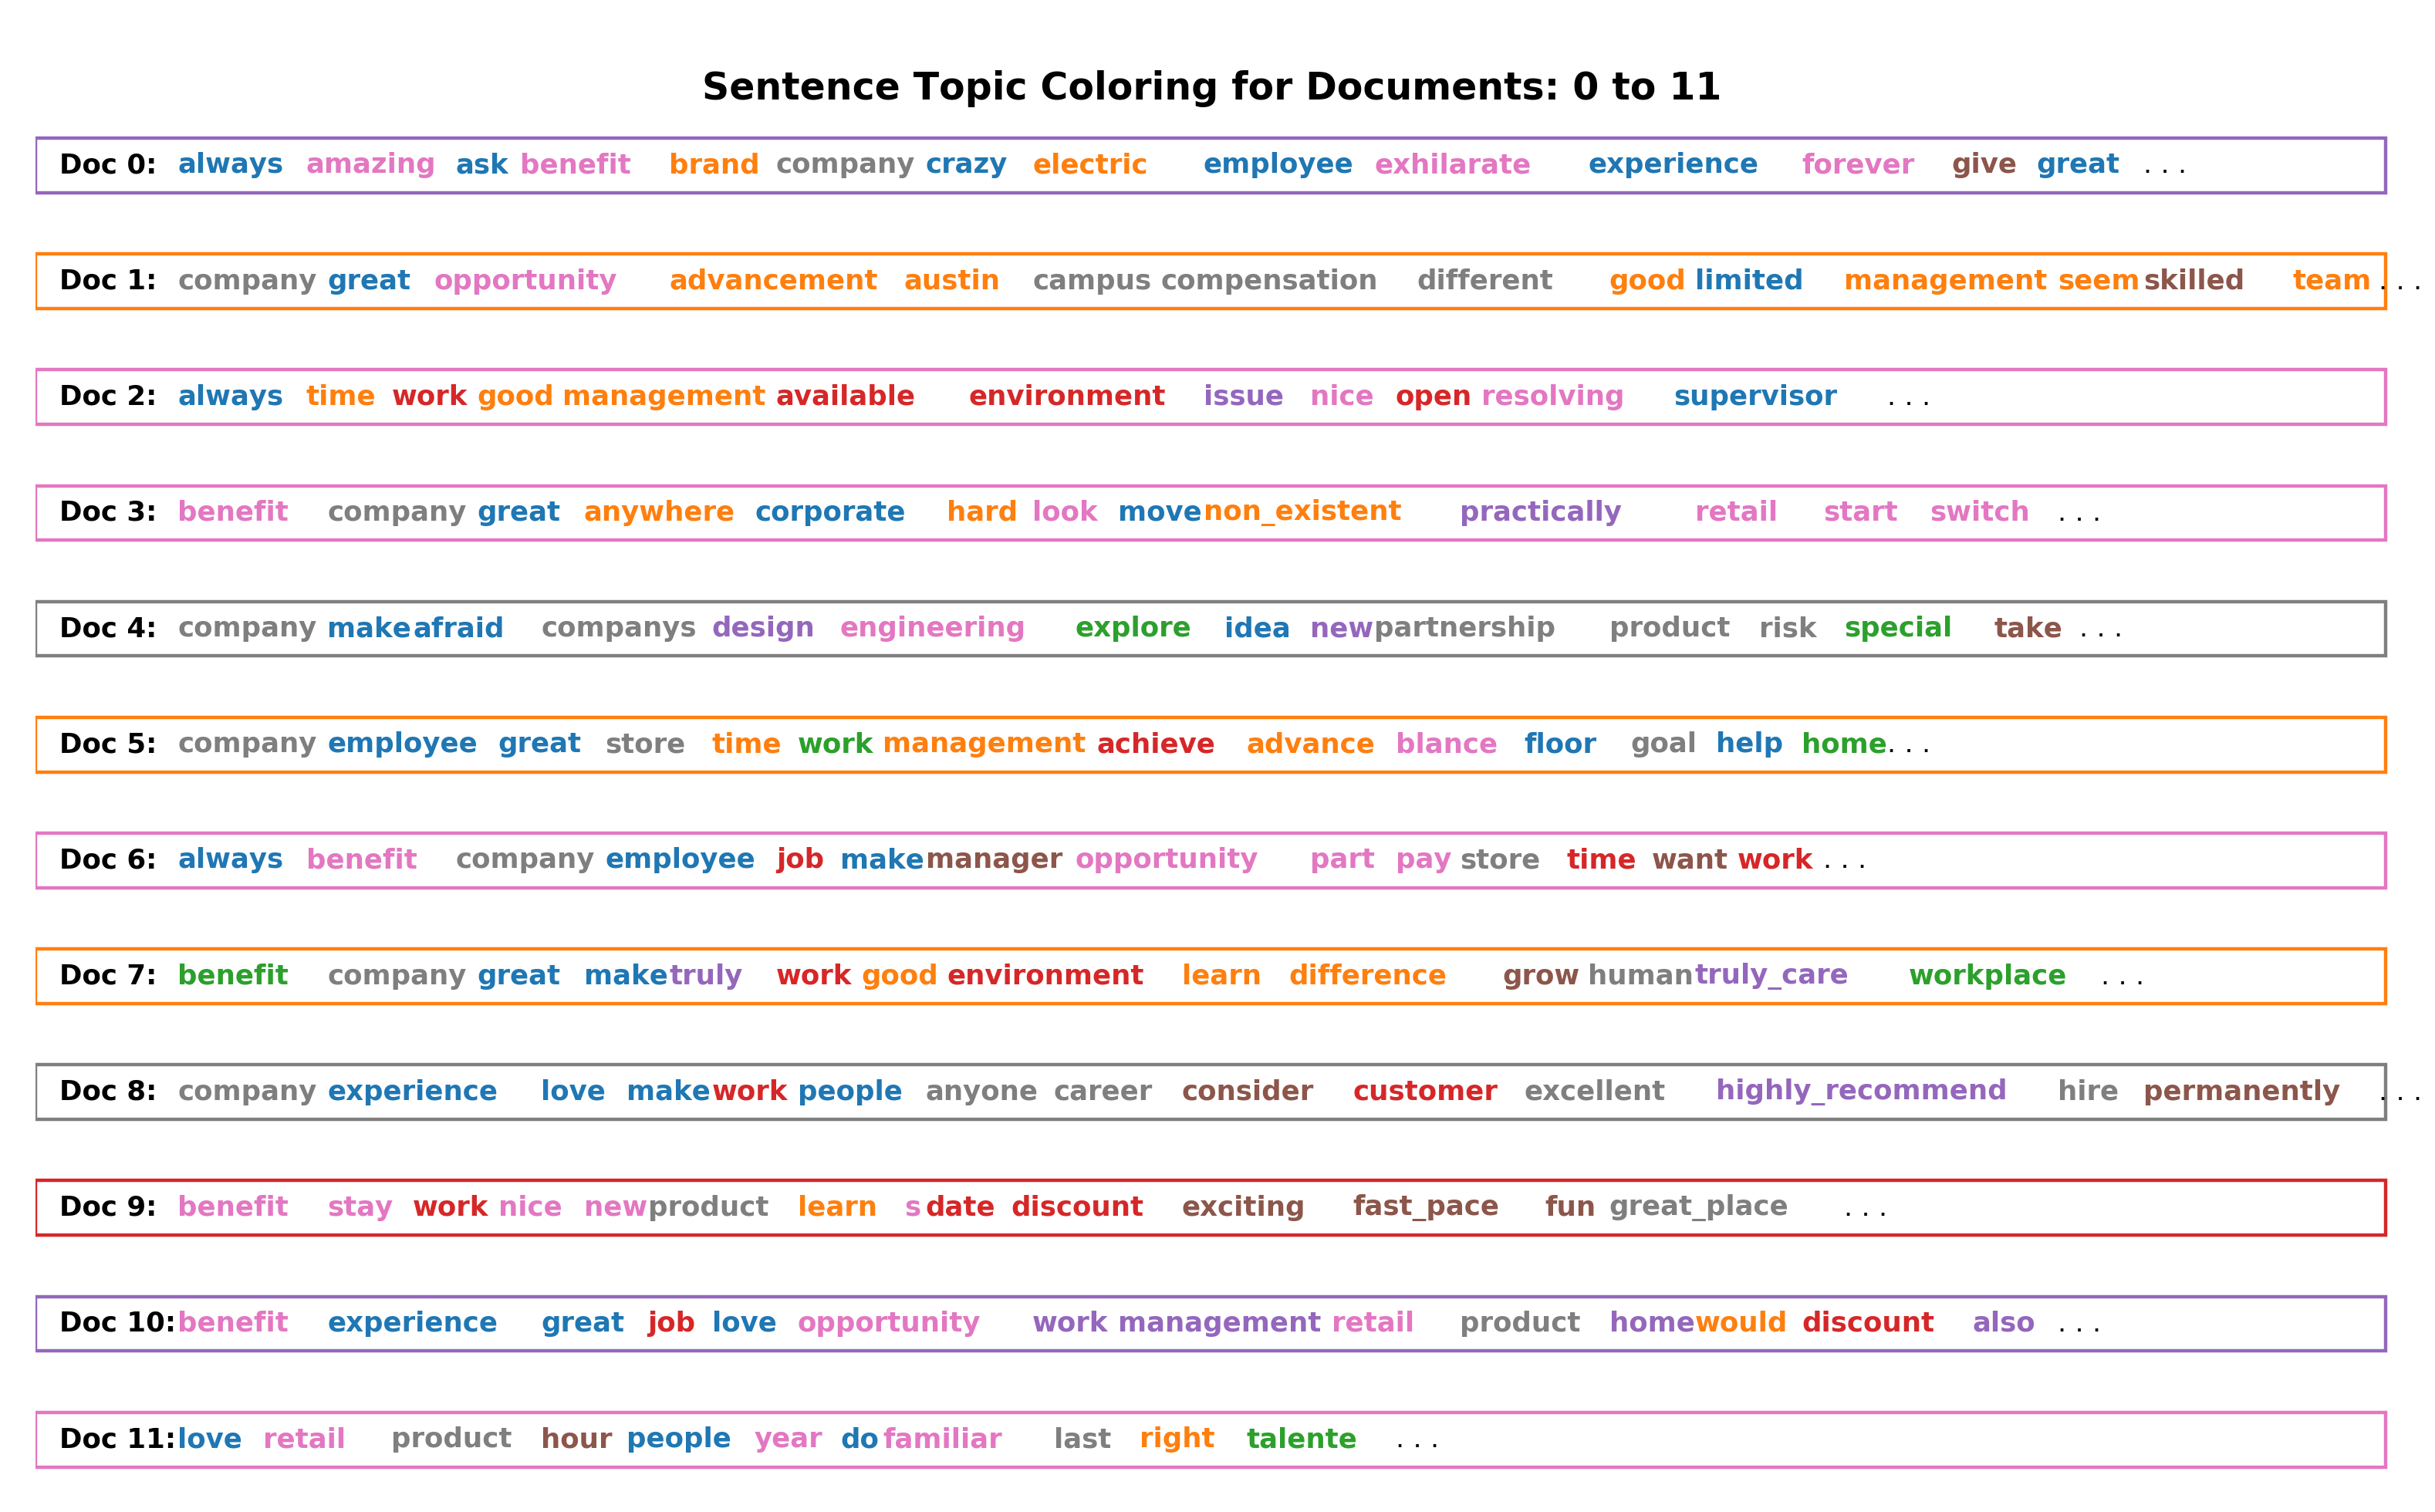

In [105]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
#     print(len(corp))
#     print(corp)
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
#             print(corp_cur)
#             break
#             print(lda_model[corp_cur])
#             break
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [107]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
#         topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

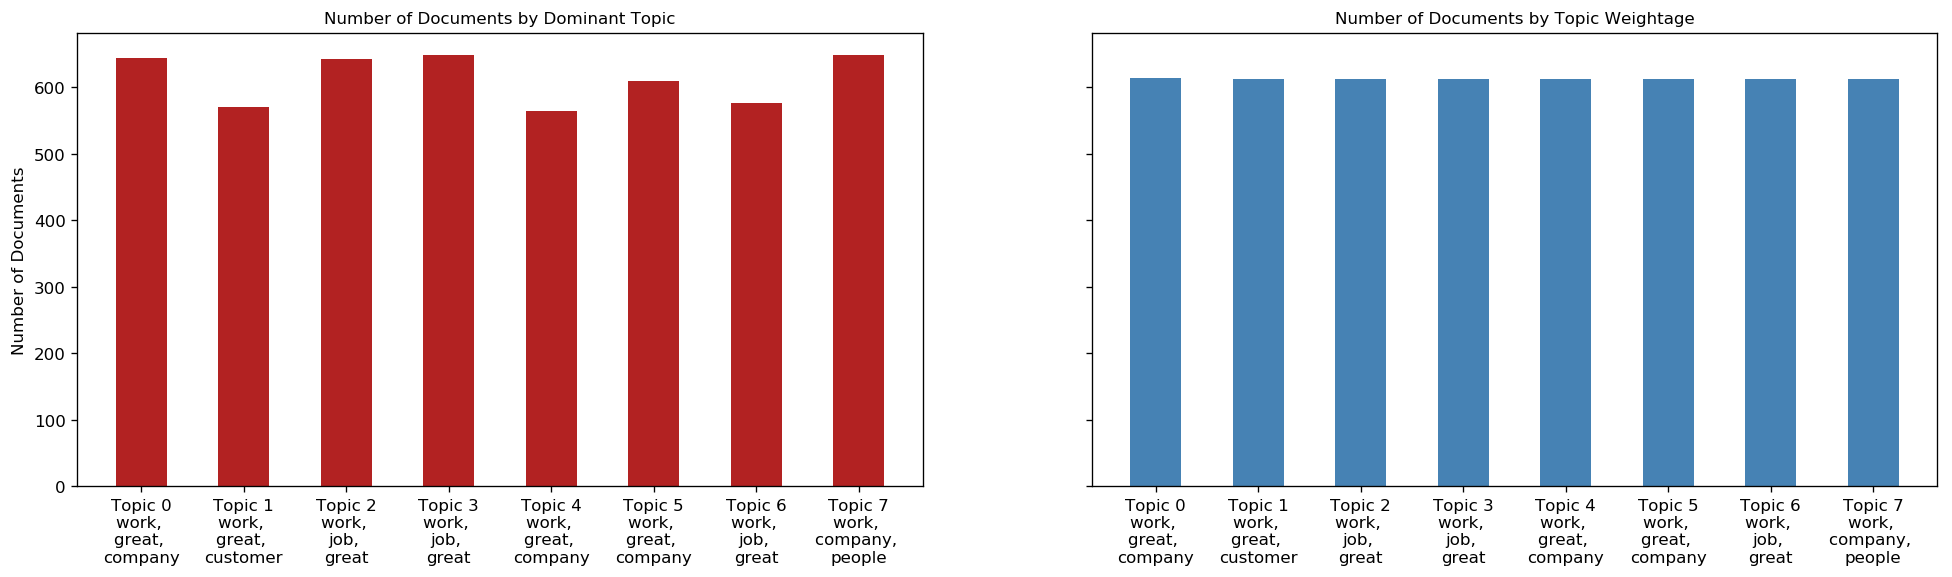

In [108]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4905 samples in 0.002s...
[t-SNE] Computed neighbors for 4905 samples in 0.434s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4905
[t-SNE] Computed conditional probabilities for sample 2000 / 4905
[t-SNE] Computed conditional probabilities for sample 3000 / 4905
[t-SNE] Computed conditional probabilities for sample 4000 / 4905
[t-SNE] Computed conditional probabilities for sample 4905 / 4905
[t-SNE] Mean sigma: 0.001578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.932869
